# 机器学习常用软件包介绍

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import seaborn as sns

## 读入数据

在此次竞赛的数据集中，每个样本都对应一个葡萄牙大学的学生。原始数据集中共有4424名学生，Kaggle基于原始数据集生成了超过100,000个合成样本。对于每个学生，我们获得了人口统计数据、宏观经济数据以及课程前两个学期的表现。竞赛的目标是预测学生在三年或四年学习后的状态：是否毕业、仍在就读，或退学。

In [4]:
train_df = pd.read_csv('../input/train.csv', index_col=0)

In [5]:
test_df = pd.read_csv('../input/test.csv', index_col=0)

In [6]:
train_df.shape[0], test_df.shape[0]

(76518, 51012)

In [7]:
(train_df.columns[:-1] == test_df.columns).all()

True

In [7]:
train_df.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
id,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,9238,1,1,126.0,1,1,19,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,17,1,9238,1,1,125.0,1,19,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,1,17,2,9254,1,1,137.0,1,3,19,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,1,1,3,9500,1,1,131.0,1,19,3,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,1,1,2,9500,1,1,132.0,1,19,37,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 76518 entries, 0 to 76517
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  76518 non-null  int64  
 1   Application mode                                76518 non-null  int64  
 2   Application order                               76518 non-null  int64  
 3   Course                                          76518 non-null  int64  
 4   Daytime/evening attendance                      76518 non-null  int64  
 5   Previous qualification                          76518 non-null  int64  
 6   Previous qualification (grade)                  76518 non-null  float64
 7   Nacionality                                     76518 non-null  int64  
 8   Mother's qualification                          76518 non-null  int64  
 9   Father's qualification                      

数据说明：https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success

In [9]:
ori_all_feats = [col for col in train_df.columns if col != 'Target']

In [10]:
ori_cat_feats = [
    'Marital status',
    'Application mode',
    'Application order',
    'Course',
    'Daytime/evening attendance',
    'Previous qualification',
    'Nacionality',
    'Mother\'s qualification',
    'Father\'s qualification',
    'Mother\'s occupation',
    'Father\'s occupation',
    'Displaced',
    'Educational special needs',
    'Debtor',
    'Tuition fees up to date',
    'Gender',
    'Scholarship holder',
    'International',
]

In [11]:
ori_num_feats = [
    'Previous qualification (grade)',
    'Admission grade',
    'Age at enrollment',
    'Curricular units 1st sem (credited)',
    'Curricular units 1st sem (enrolled)',
    'Curricular units 1st sem (evaluations)',
    'Curricular units 1st sem (approved)',
    'Curricular units 1st sem (grade)',
    'Curricular units 1st sem (without evaluations)',
    'Curricular units 2nd sem (credited)',
    'Curricular units 2nd sem (enrolled)',
    'Curricular units 2nd sem (evaluations)',
    'Curricular units 2nd sem (approved)',
    'Curricular units 2nd sem (grade)',
    'Curricular units 2nd sem (without evaluations)',
    'Unemployment rate',
    'Inflation rate',
    'GDP',
]

In [12]:
set(ori_all_feats) == ( set(ori_cat_feats) | set(ori_num_feats) )

True

In [13]:
len(ori_all_feats), len(ori_cat_feats) + len(ori_num_feats)

(36, 36)

## EDA

### Target

In [17]:
target_classes = train_df['Target'].value_counts()
target_classes

Target
Graduate    36282
Dropout     25296
Enrolled    14940
Name: count, dtype: int64

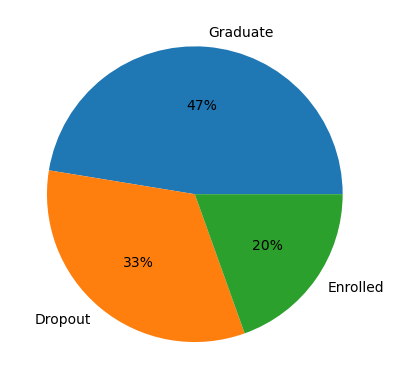

In [18]:
_ = plt.pie(target_classes, labels=target_classes.index, autopct="%.0f%%")

存在类别不均衡，不过不严重，可以不用特意处理

### 类别特征

两个无序分类变量的相关性，可通过 Cramer’s V 系数衡量，值的范围在 0 到 1 之间，0表示完全不相关，1表示完全相关。[0, 0.2] 弱相关，(0.2, 0.6]中等相关，(0.6, 1.0)强相关。

![](./random_variable_correlation.png)

- 连续变量 vs 连续变量：Pearson’s correlation coefficient
- 连续变量 vs 分类变量：Eta squared
- 分类变量 vs 分类变量：卡方检验、Cramer’s V

In [16]:
import scipy.stats as ss

def cramers_corrected_stat(var1, var2):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(var1, var2)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [17]:
len(ori_cat_feats)

18

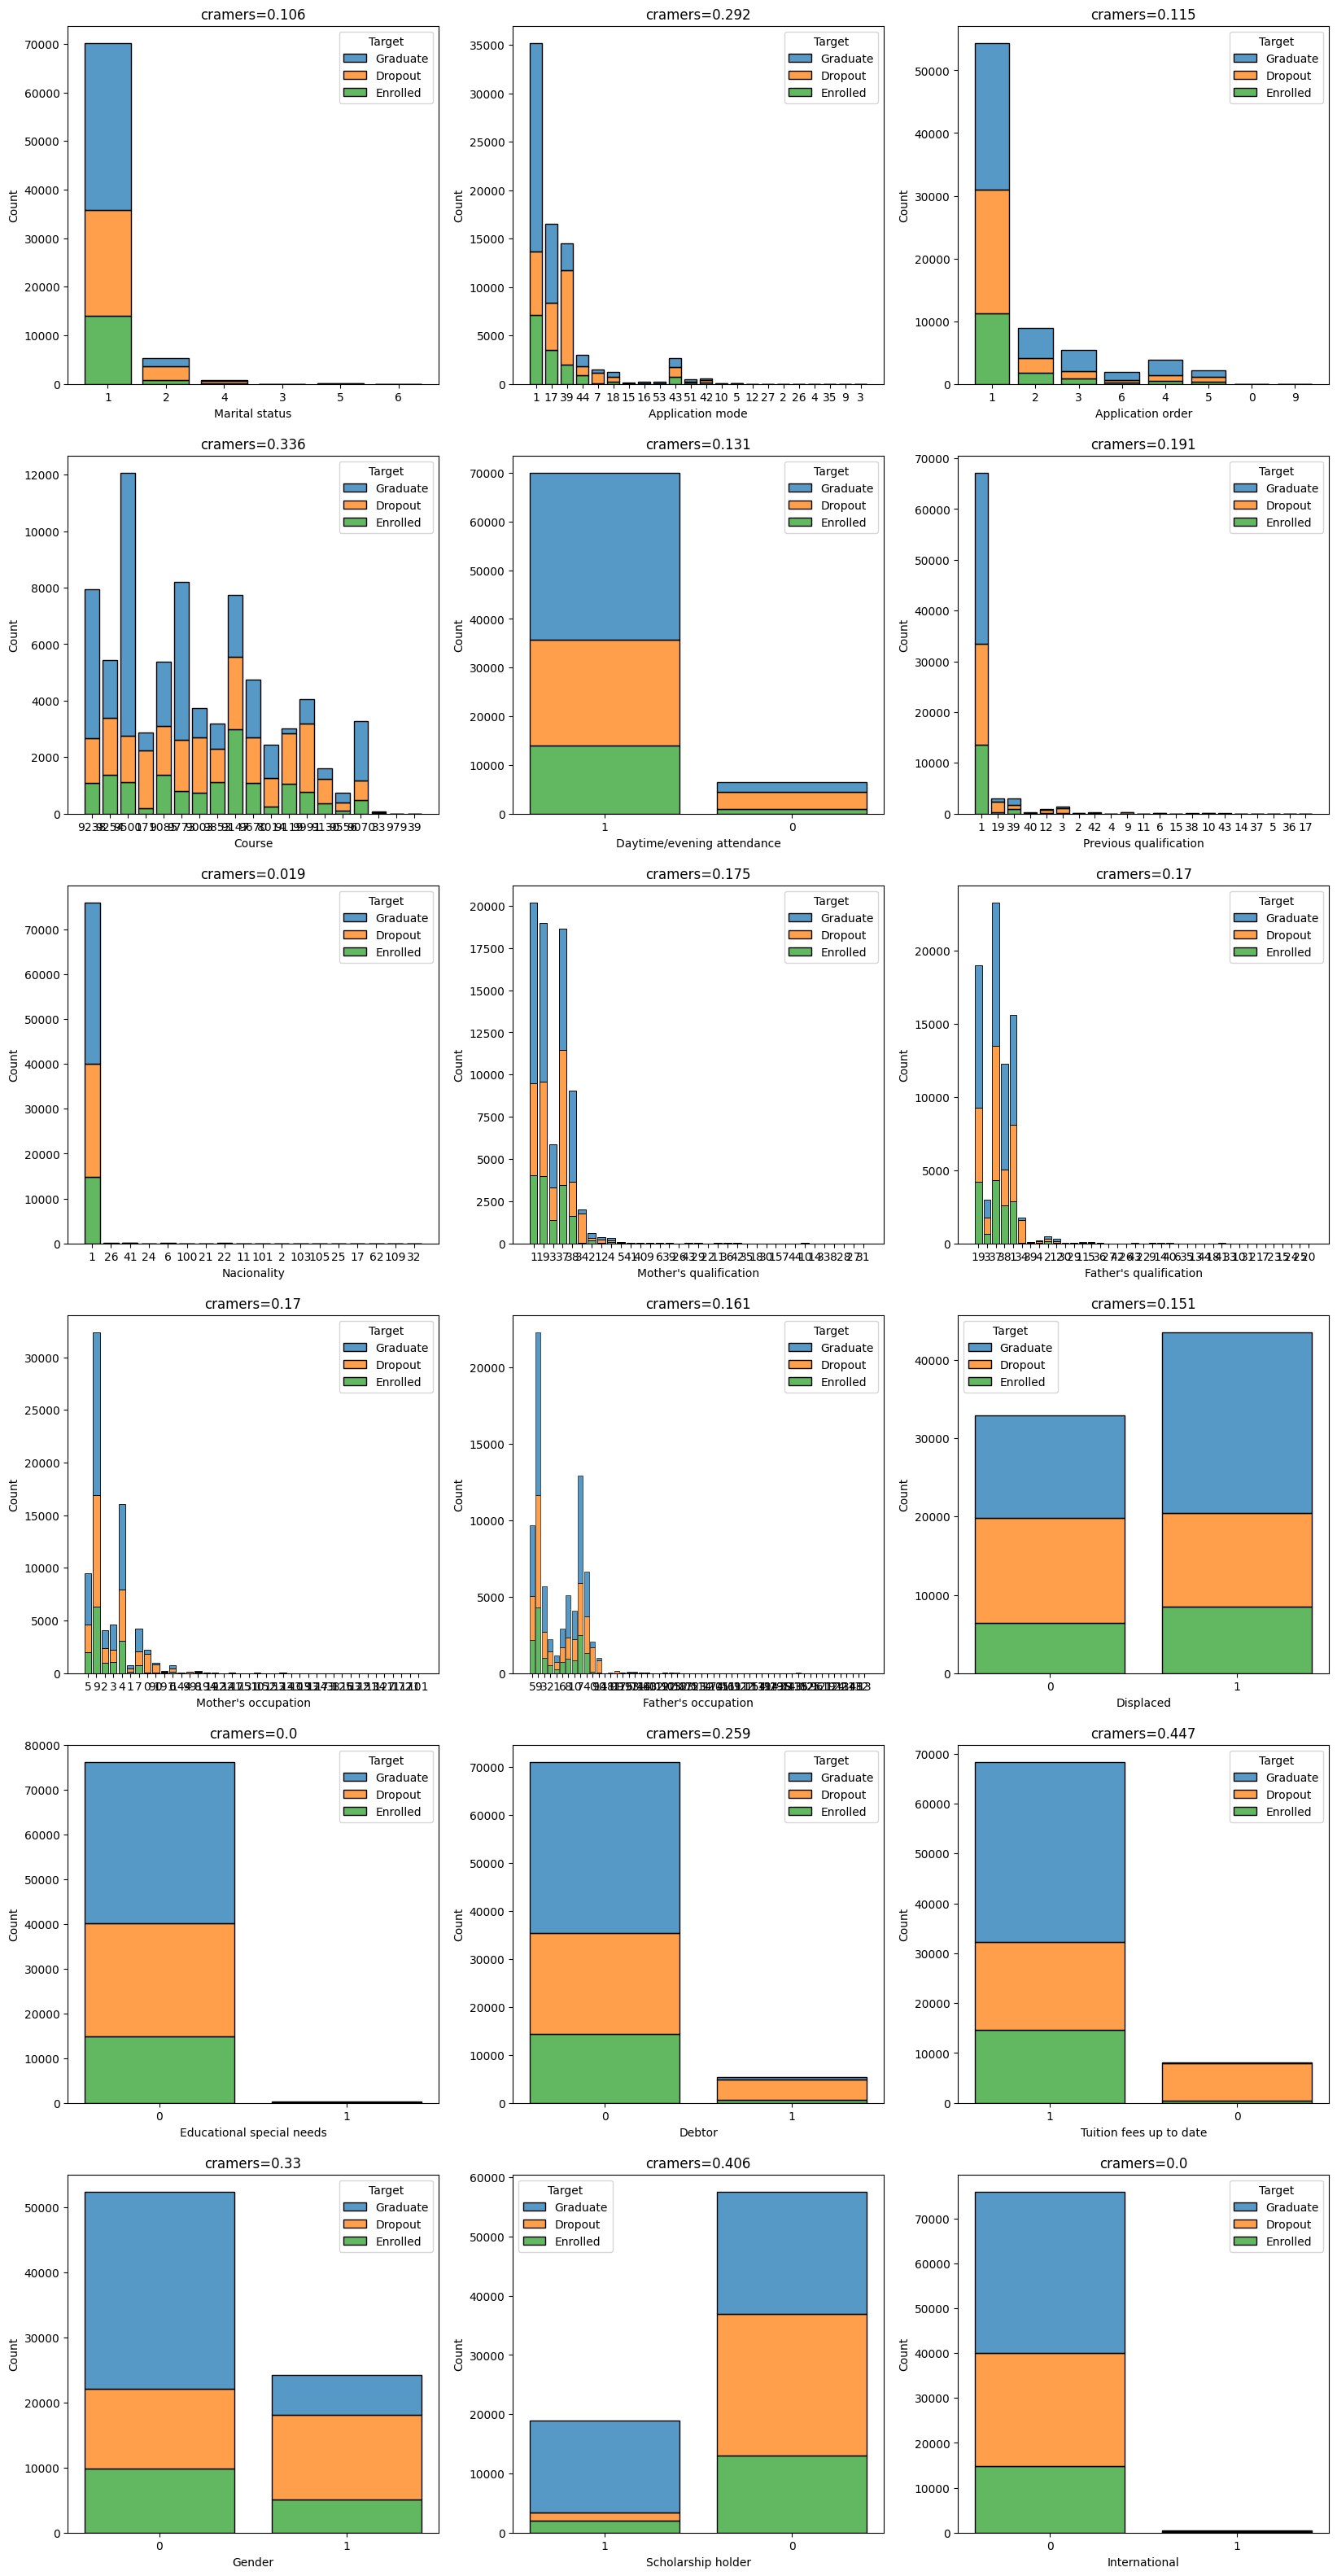

In [62]:
plt.figure(figsize=(20, 40))

for i, col in enumerate(ori_cat_feats, 1):
    plt.subplot(6, 3, i)
    cramers = round(cramers_corrected_stat(train_df[col], train_df['Target']), 3)
    sns.histplot(x=train_df[col].astype('str'), hue=train_df['Target'], stat='count', multiple='stack', shrink=0.8)
    plt.title(f'cramers={cramers}')

两两相关性：

In [71]:
cat_feats = ['Target'] + ori_cat_feats

In [72]:
N = len(cat_feats)
cat_feats_corr_mat = np.zeros((N, N))

In [74]:
for i in range(N - 1):
    for j in range(i, N):
        col_i = cat_feats[i]
        col_j = cat_feats[j]
        cat_feats_corr_mat[i, j] = cat_feats_corr_mat[j, i] = cramers_corrected_stat(train_df[col_i], train_df[col_j])

<Axes: >

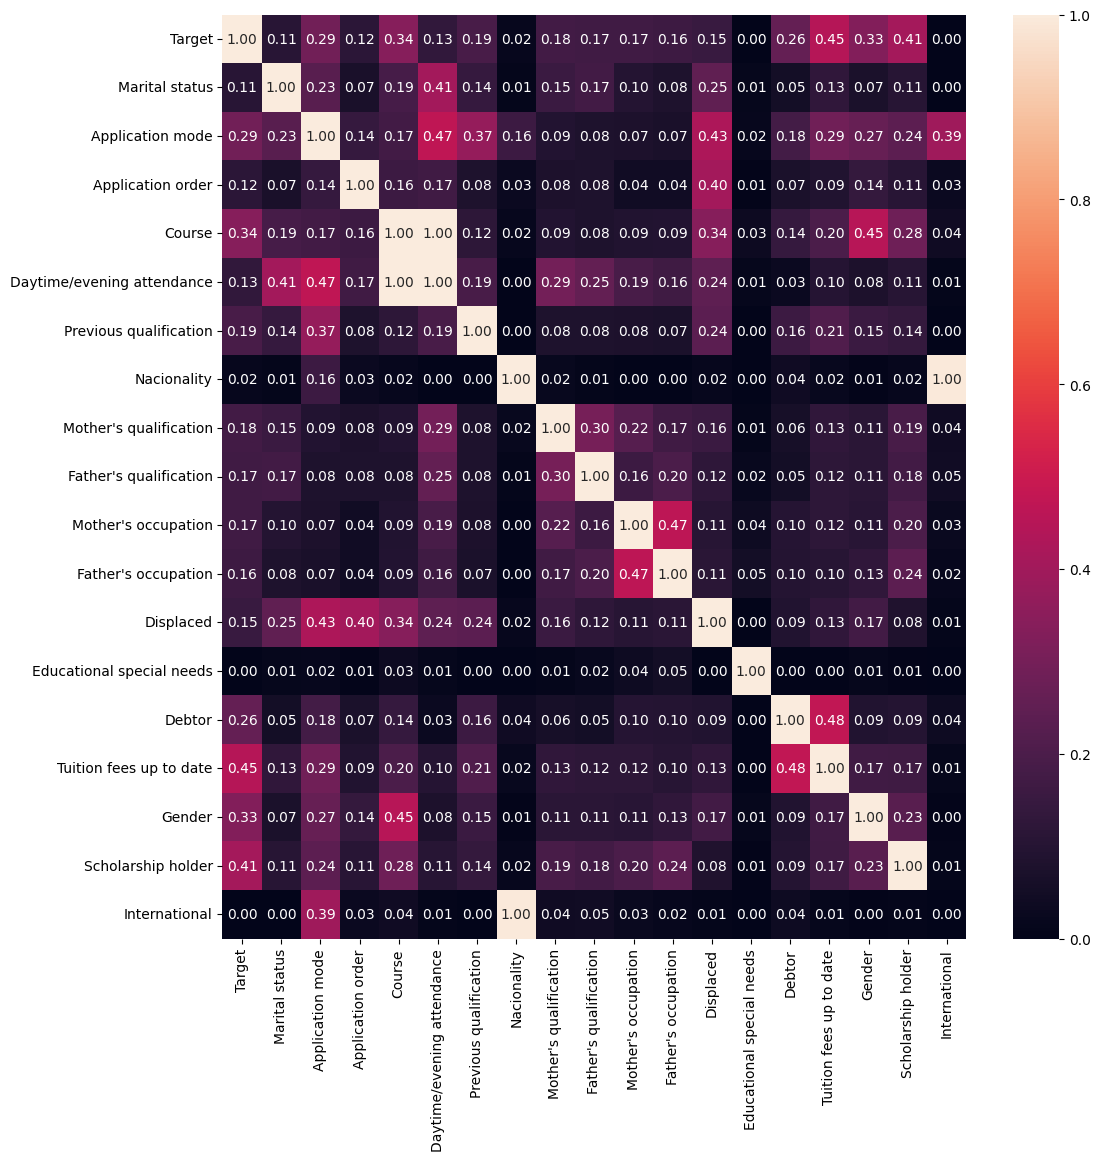

In [87]:
plt.figure(figsize=(12, 12))
sns.heatmap(cat_feats_corr_mat, annot=True, fmt='.2f', xticklabels=cat_feats, yticklabels=cat_feats)

- 与Target中等相关的：Tuition fees up to date(学费已缴纳至最新日期)、Scholarship holder(奖学金获得者)、Gender(性别)、Course(课程)
- Course 与 Daytime/evening attendance 强相关
- Nacionality 与 International 强相关
- Application mode 与 Daytime/evening attendance 中等相关
- Debtor 与 Tuition fees up to date 中等相关
- ...

### 连续特征

连续随机变量与分类随机变量间相关性，通过 Eta squared 衡量，取值范围 0～1，0表示完全不相关，1表示完全相关。
- 0.01: Small effect size
- 0.06: Medium effect size
- 0.14 or higher: Large effect size

In [91]:
import pingouin as pg

In [97]:
len(ori_num_feats)

18

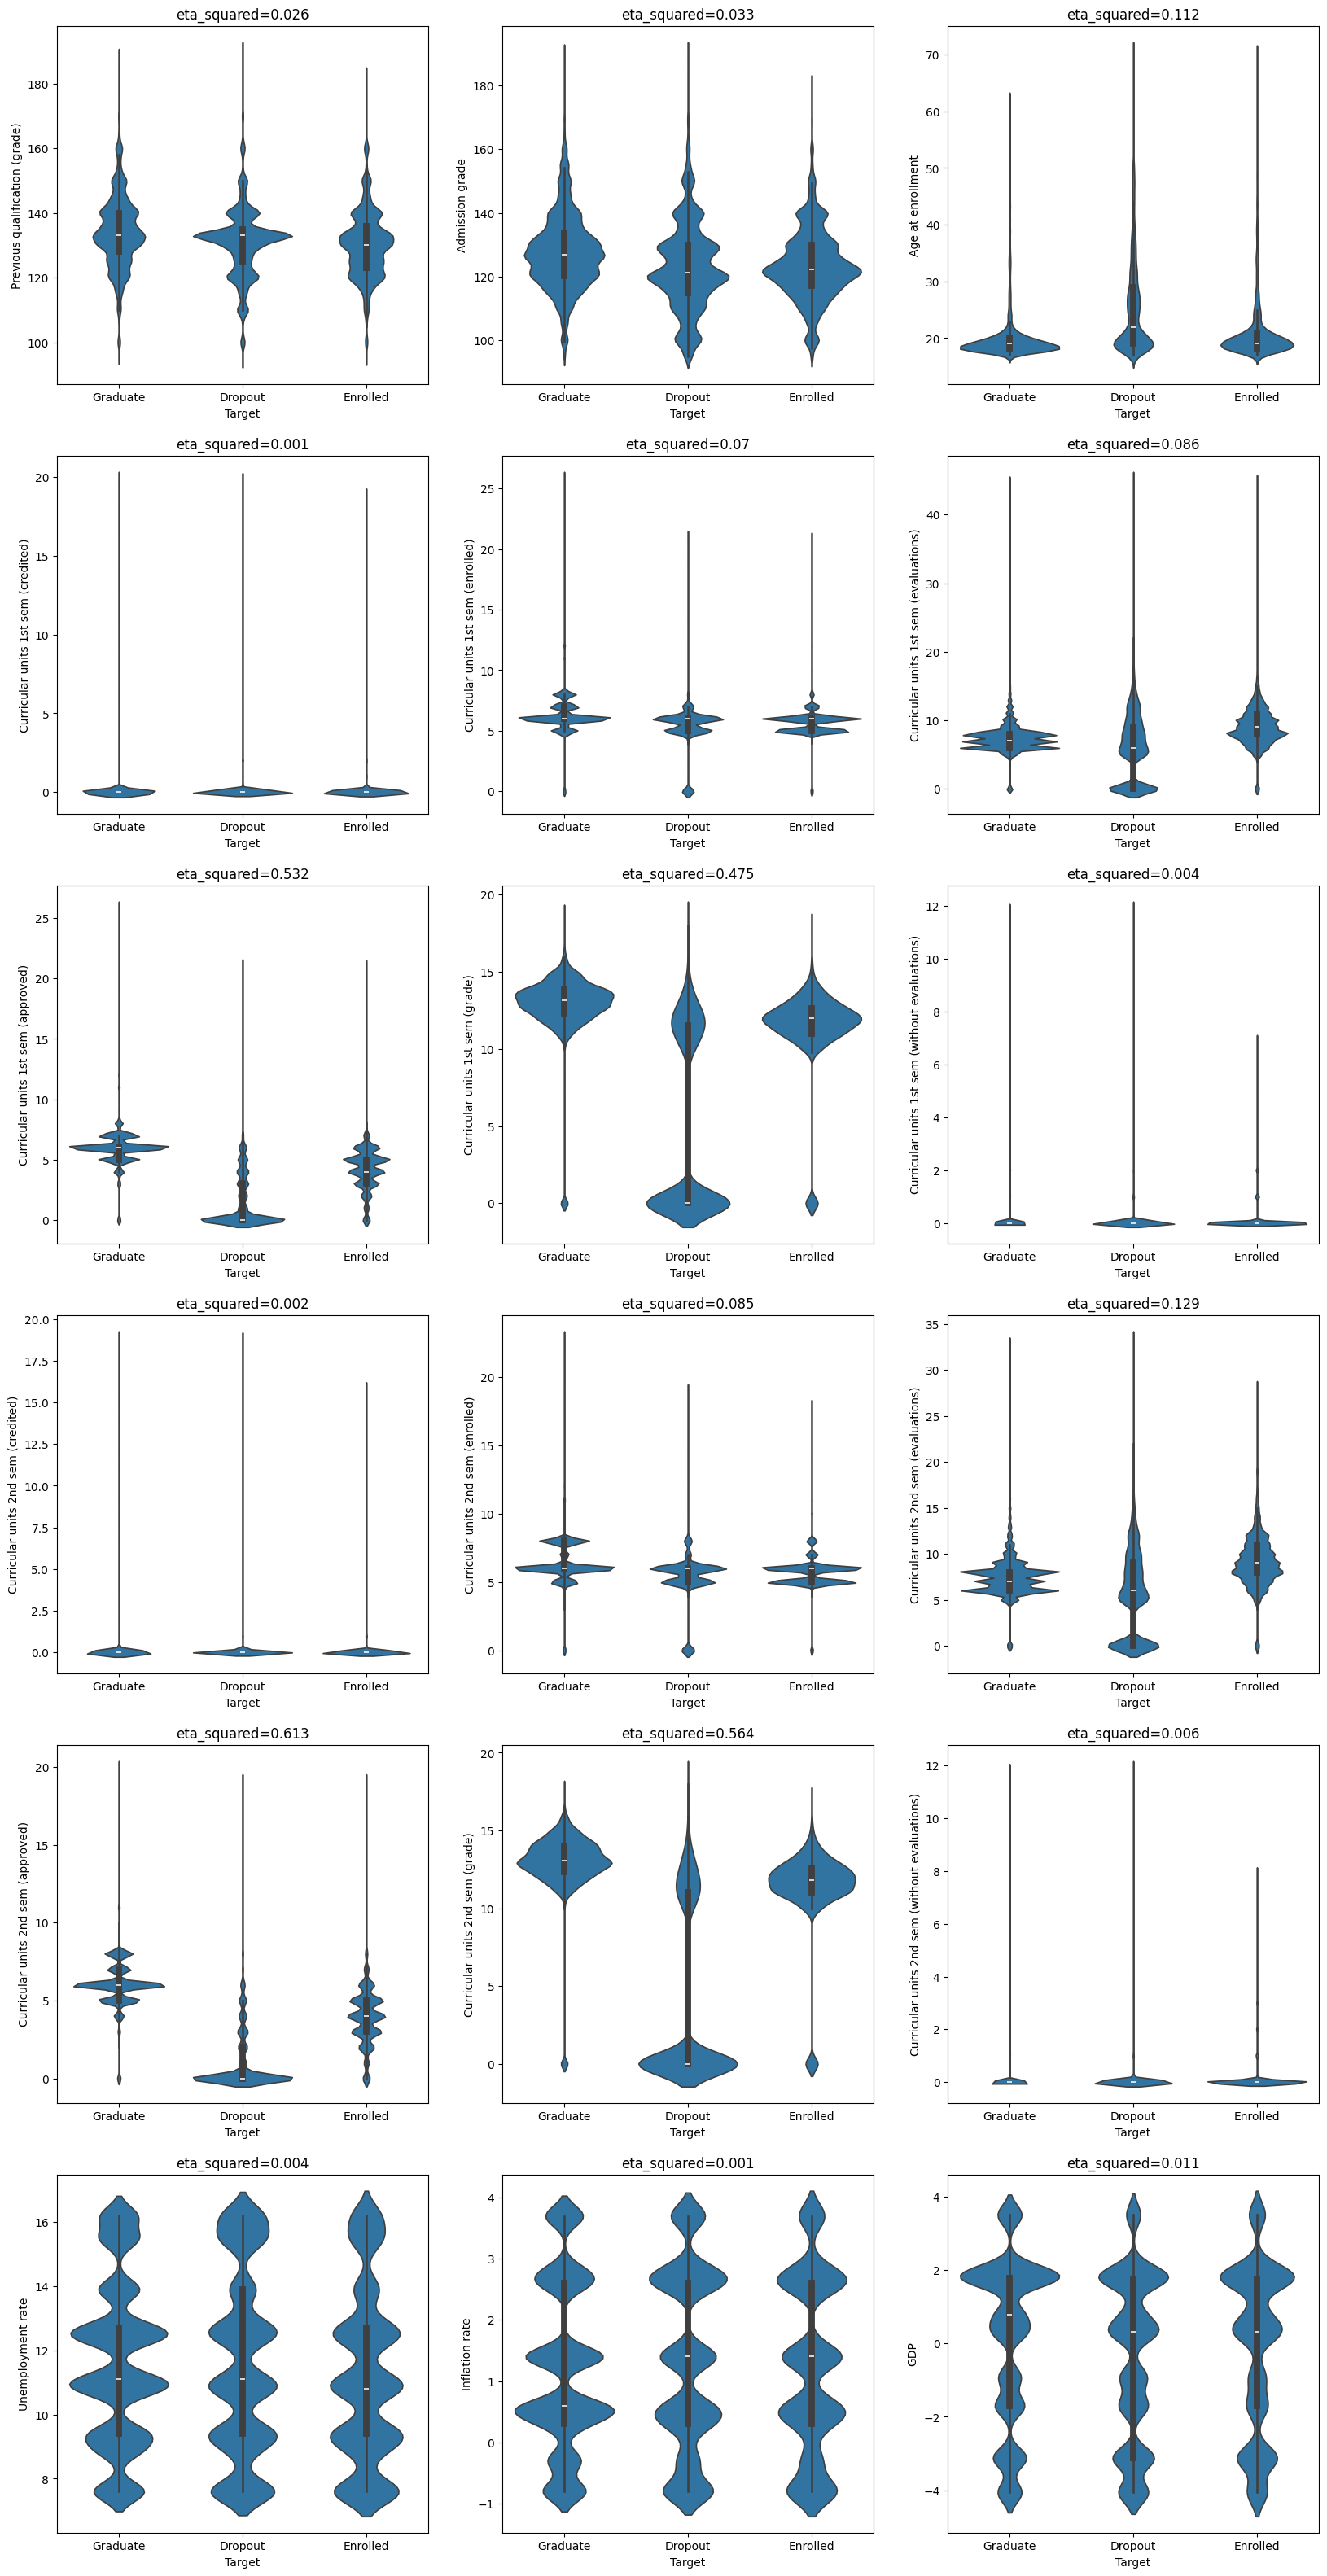

In [101]:
plt.figure(figsize=(20, 40))

eta_squared_scores = []
for i, col in enumerate(ori_num_feats, 1):
    plt.subplot(6, 3, i)
    anova_results = pg.anova(data=train_df, dv=col, between='Target')
    eta_squared = round(anova_results['np2'][0], 3)
    eta_squared_scores.append(eta_squared)
    
    sns.violinplot(x='Target', y=col, data=train_df)
    plt.title(f'eta_squared={eta_squared}')

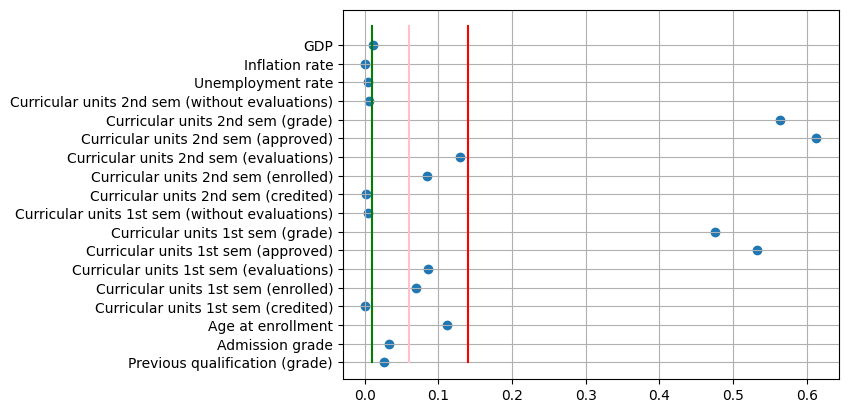

In [114]:
plt.scatter(eta_squared_scores, range(len(ori_num_feats)))
_ = plt.yticks(range(len(ori_num_feats)), labels=ori_num_feats)
plt.plot([0.01, 0.01], [0, 18], color='green')
plt.plot([0.06, 0.06], [0, 18], color='pink')
plt.plot([0.14, 0.14], [0, 18], color='red')
plt.grid()

- 与 Target 强相关的：Curricular units 2nd sem (approved)、Curricular units 2nd sem (grade)、Curricular units 1st sem (approved)、Curricular units 1st sem (grade)
- 与 Target 中等相关的：Curricular units 2nd sem (evaluations)、Curricular units 1st sem (enrolled)、Curricular units 1st sem (evaluations)、Curricular units 2nd sem (enrolled)、Age at enrollment

连续变量两两相关性：

In [117]:
cat_feats_corr_mat = np.corrcoef(train_df[ori_num_feats], rowvar=False)

<Axes: >

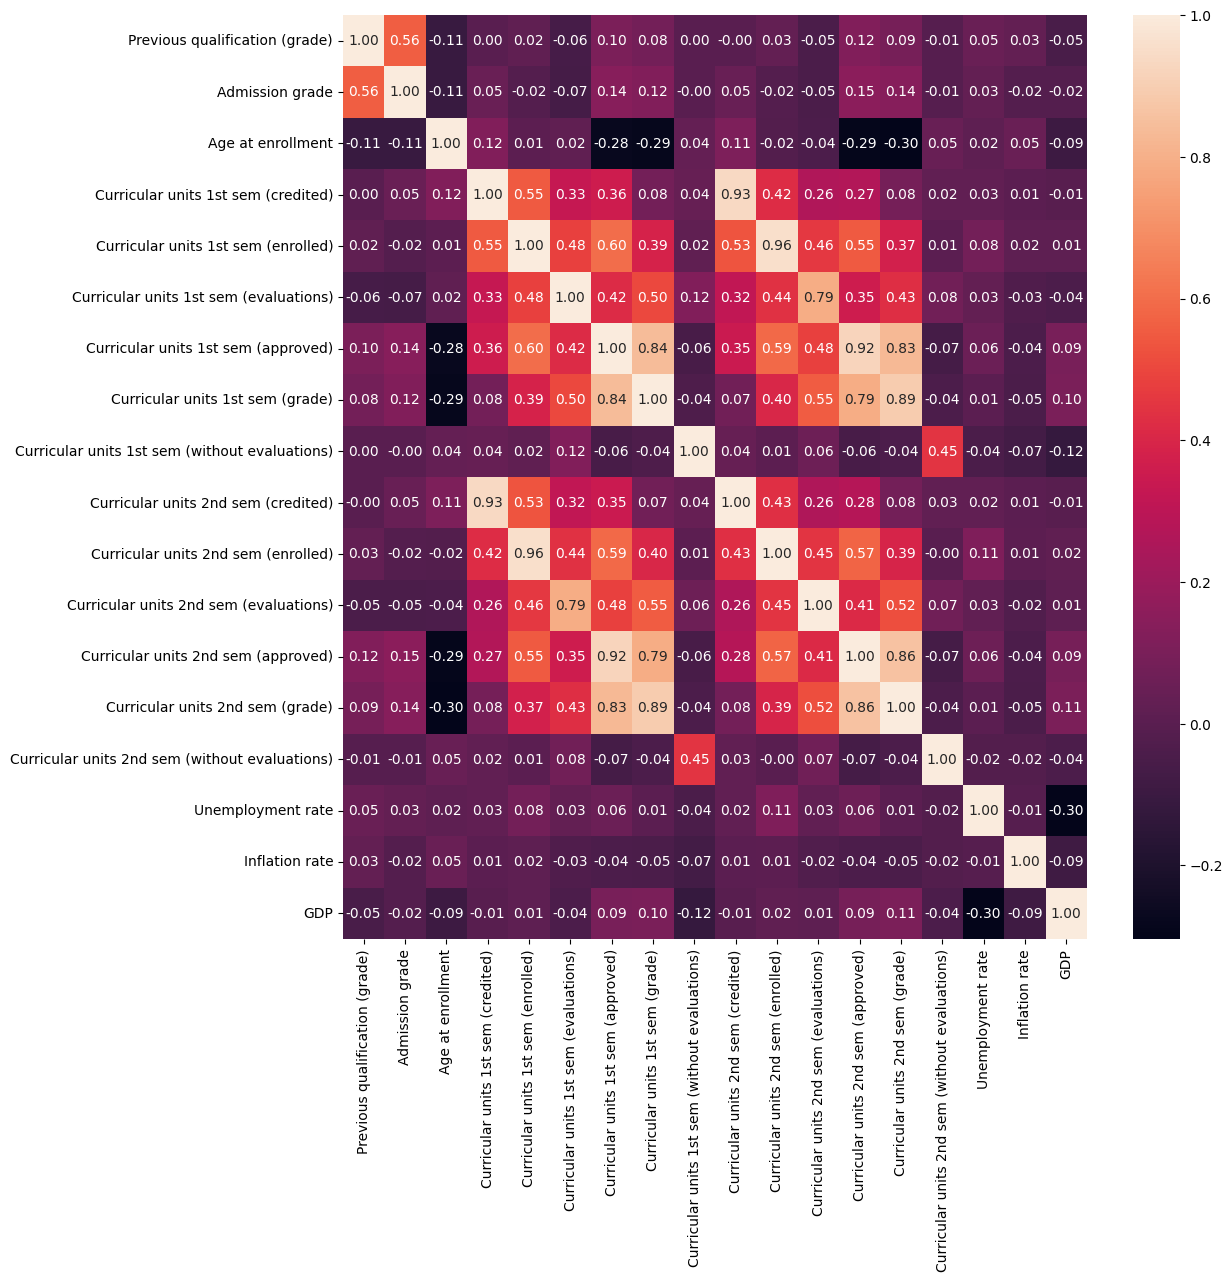

In [119]:
plt.figure(figsize=(12, 12))
sns.heatmap(cat_feats_corr_mat, annot=True, fmt='.2f', xticklabels=ori_num_feats, yticklabels=ori_num_feats)

- Curricular units 2nd 与 Curricular units 1st 多个变量分别相关

## 建模

In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import ExtraTreeClassifier

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

- Tree-based 模型不需要对特征进行诸如StandardScaler MinMaxScaler之类的缩放
- 类别特征需要做one-hot编码

使用 pd.get_dummies 做 one-hot 编码演示：

In [150]:
df = pd.DataFrame([
    [0, 1, 2],
    [1, 3, 5]
], columns=['A', 'B', 'C'])

In [151]:
df

,A,B,C
0,0,1,2
1,1,3,5


In [155]:
pd.get_dummies(df, columns=['B', 'C'], dtype=np.float32)

,A,B_1,B_3,C_2,C_5
0,0,1.0,0.0,1.0,0.0
1,1,0.0,1.0,0.0,1.0


In [20]:
com_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)

In [21]:
need_one_hot_encode_cols = [c for c in ori_cat_feats if com_df[c].nunique() > 2]

In [22]:
com_df = pd.get_dummies(com_df, columns=need_one_hot_encode_cols, dtype=np.float32)

In [24]:
com_df.shape

(127530, 310)

In [165]:
print('\n'.join(com_df.columns))

Daytime/evening attendance
Previous qualification (grade)
Admission grade
Displaced
Educational special needs
Debtor
Tuition fees up to date
Gender
Scholarship holder
Age at enrollment
International
Curricular units 1st sem (credited)
Curricular units 1st sem (enrolled)
Curricular units 1st sem (evaluations)
Curricular units 1st sem (approved)
Curricular units 1st sem (grade)
Curricular units 1st sem (without evaluations)
Curricular units 2nd sem (credited)
Curricular units 2nd sem (enrolled)
Curricular units 2nd sem (evaluations)
Curricular units 2nd sem (approved)
Curricular units 2nd sem (grade)
Curricular units 2nd sem (without evaluations)
Unemployment rate
Inflation rate
GDP
Target
Marital status_1
Marital status_2
Marital status_3
Marital status_4
Marital status_5
Marital status_6
Application mode_1
Application mode_2
Application mode_3
Application mode_4
Application mode_5
Application mode_7
Application mode_9
Application mode_10
Application mode_12
Application mode_14
Applicat

In [196]:
label2code = {
    'Graduate': 0,
    'Enrolled': 1,
    'Dropout': 2,
}

In [197]:
com_df['Target'] = com_df['Target'].map(label2code)

In [198]:
com_df[target].value_counts(dropna=False)

Target
NaN    51012
0.0    36282
2.0    25296
1.0    14940
Name: count, dtype: int64

In [199]:
feats = [c for c in com_df.columns if c != 'Target']
target = 'Target'
X_trn, X_val, y_trn, y_val = train_test_split(com_df.loc[train_df.index, feats], com_df.loc[train_df.index, target], test_size=0.2, random_state=42)

In [200]:
len(X_trn), len(X_val)

(61214, 15304)

### RandomForestClassifier

In [201]:
rfc = RandomForestClassifier(n_estimators=10_000, n_jobs=32)

In [ ]:
rfc.fit(X_trn, y_trn)

In [203]:
pred = rfc.predict(X_val)

In [204]:
accuracy_score(y_val, pred)

0.8274307370622059

### ExtraTreeClassifier

In [206]:
xtree = ExtraTreeClassifier()

In [207]:
xtree.fit(X_trn, y_trn)

ExtraTreeClassifier()

In [208]:
pred = xtree.predict(X_val)

In [209]:
accuracy_score(y_val, pred)

0.704260324098275

### LightGBM

In [210]:
import lightgbm as lgb

In [222]:
params = {
    'num_threads': 8,
    'learning_rate': 0.01,
    'objective': 'multiclass',
    'num_class': 3,
    'num_leaves': 31,
    'min_data_in_leaf': 20,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.8,
    'reg_alpha': 1.0,
    'metric': 'multi_error',
    'early_stopping_rounds': 400,
}

In [223]:
trn_data = lgb.Dataset(X_trn, label=y_trn)
val_data = lgb.Dataset(X_val, label=y_val)

lgb_model = lgb.train(params, trn_data, 10000, valid_sets=val_data, callbacks=[lgb.log_evaluation(100)])

lgb_model_pred = lgb_model.predict(X_val, num_iteration=lgb_model.best_iteration)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1408
[LightGBM] [Info] Number of data points in the train set: 61214, number of used features: 152
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -0.746287
[LightGBM] [Info] Start training from score -1.635907
[LightGBM] [Info] Start training from score -1.105333
Training until validation scores don't improve for 400 rounds
[100]	valid_0's multi_error: 0.179365
[200]	valid_0's multi_error: 0.172765
[300]	valid_0's multi_error: 0.170805
[400]	valid_0's multi_error: 0.168387
[500]	valid_0's multi_error: 0.166819
[600]	valid_0's multi_error: 0.16597
[700]	valid_0's multi_error: 0.1659

In [224]:
pred = lgb_model_pred.argmax(axis=-1)

In [225]:
accuracy_score(y_val, pred)

0.8370360690015682

## 预测&生成提交文件

In [226]:
trn_data = lgb.Dataset(com_df.loc[train_df.index, feats], label=com_df.loc[train_df.index, target])

lgb_model = lgb.train(params, trn_data, 2000, valid_sets=trn_data, callbacks=[lgb.log_evaluation(200)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1422
[LightGBM] [Info] Number of data points in the train set: 76518, number of used features: 156
[LightGBM] [Info] Start training from score -0.746204
[LightGBM] [Info] Start training from score -1.633484
[LightGBM] [Info] Start training from score -1.106880


/home/admin/jiazhuang.jz/miniconda3/envs/py38/lib/python3.8/site-packages/lightgbm/callback.py:340: UserWarning: Only training set found, disabling early stopping.
  _log_warning('Only training set found, disabling early stopping.')


[200]	training's multi_error: 0.17243
[400]	training's multi_error: 0.165739
[600]	training's multi_error: 0.159949
[800]	training's multi_error: 0.156081
[1000]	training's multi_error: 0.152788
[1200]	training's multi_error: 0.150069
[1400]	training's multi_error: 0.147246
[1600]	training's multi_error: 0.144567
[1800]	training's multi_error: 0.142006
[2000]	training's multi_error: 0.139614


In [227]:
pred = lgb_model.predict(com_df.loc[test_df.index, feats])

In [229]:
pred = pred.argmax(axis=-1)

In [235]:
test_df[target] = pred

In [239]:
code2label = {v: k for k, v in label2code.items()}

In [241]:
test_df[target] = test_df[target].map(code2label)

In [242]:
cols = [target]
test_df[cols].to_csv('simple_lgb_split8370.csv', index=True, header=True)

In [243]:
!head simple_lgb_split8370.csv

id,Target
76518,Dropout
76519,Graduate
76520,Graduate
76521,Enrolled
76522,Enrolled
76523,Graduate
76524,Graduate
76525,Graduate
76526,Dropout
